In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from PIL import Image
import cv2

In [2]:
path='/Users/alisa/Downloads/archive/boneage-training-dataset/boneage-training-dataset/'
training_images=os.listdir(path)
path_val = '/Users/alisa/Downloads/archive/boneage-validation-dataset/'
validation_images=os.listdir(path_val)

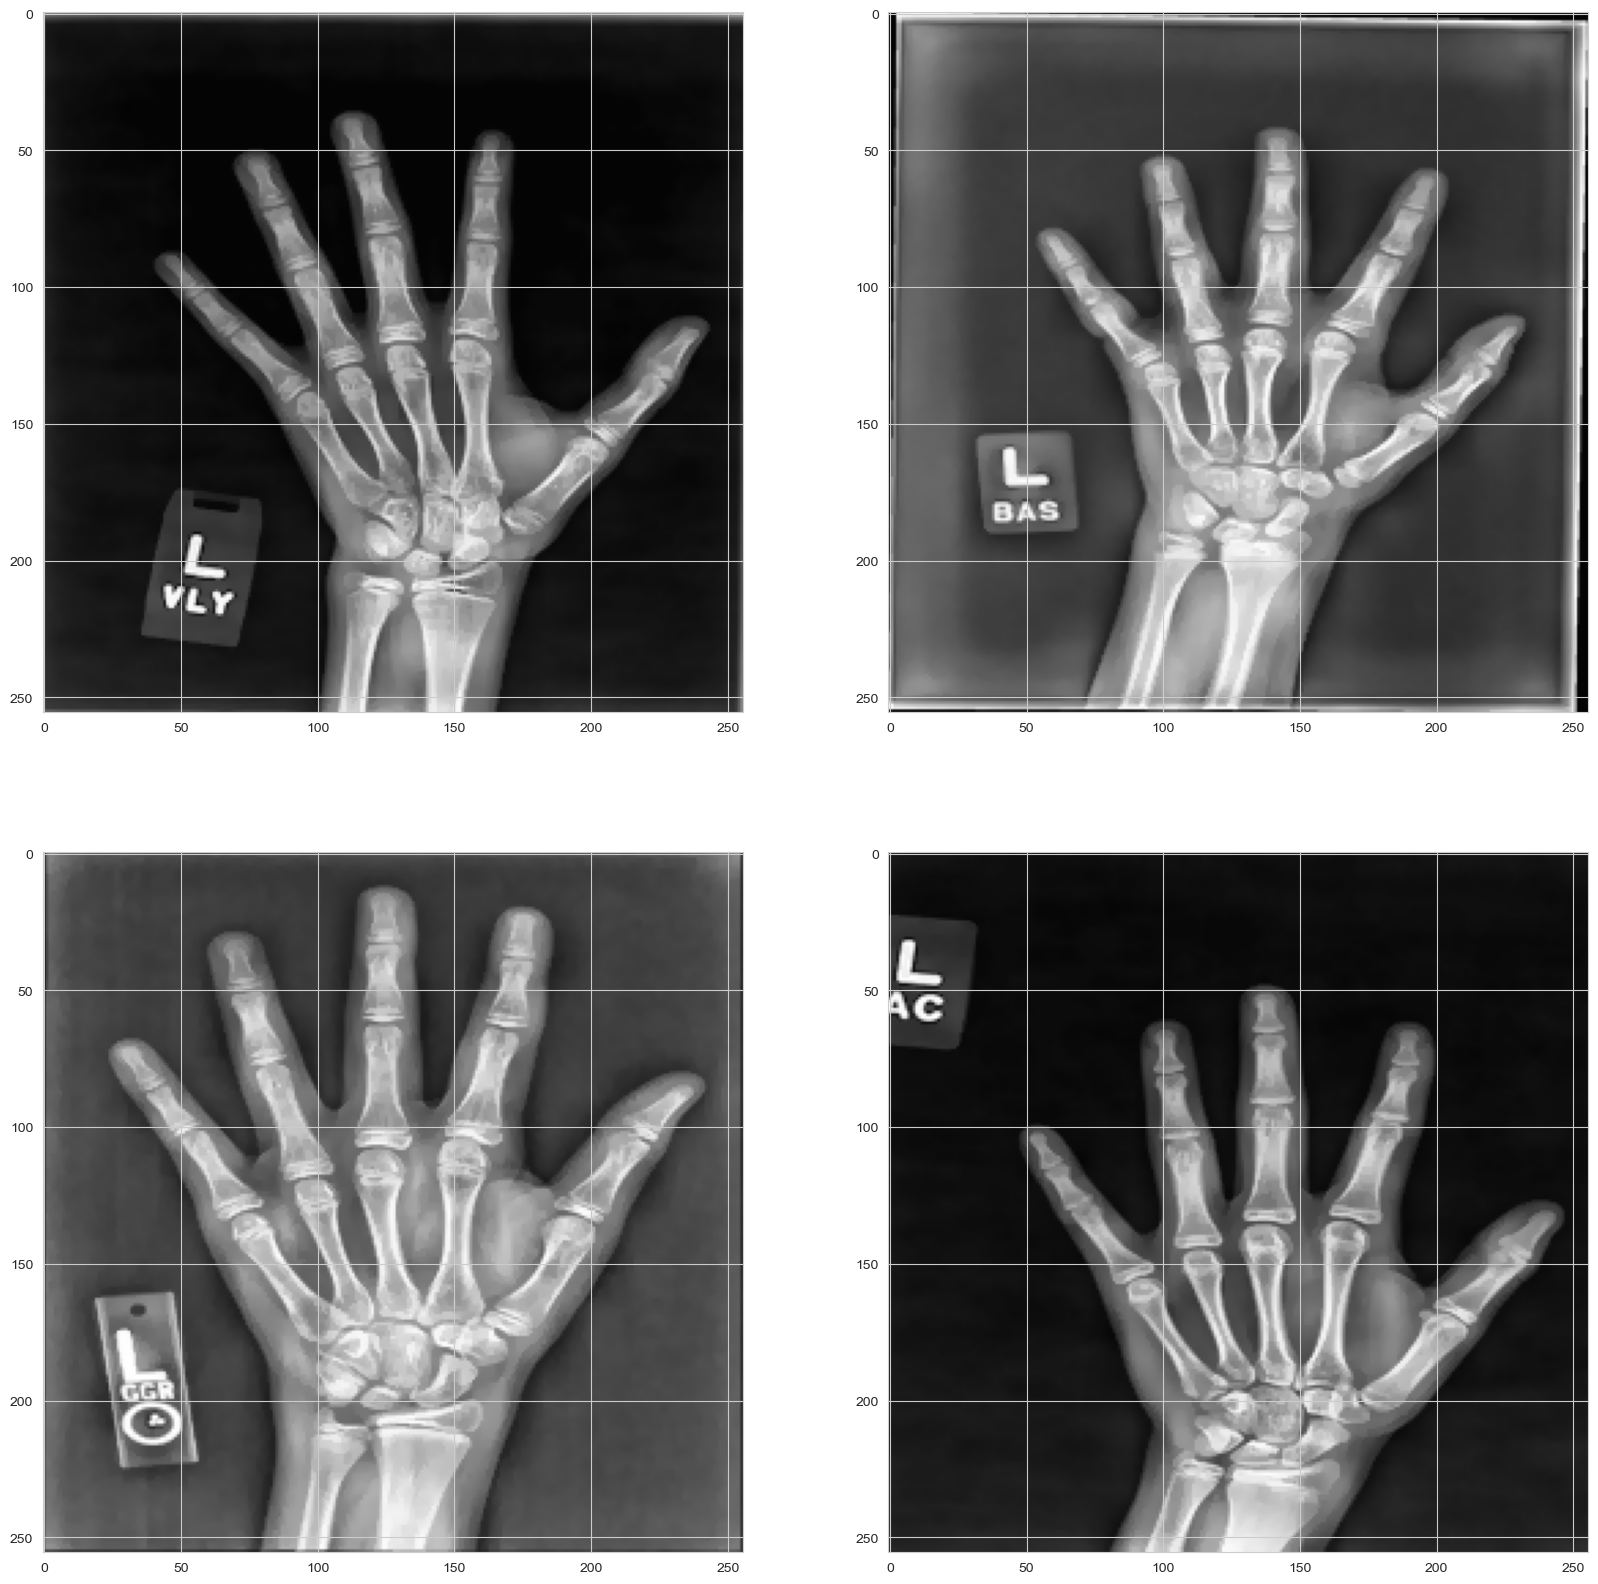

In [3]:
#Plotting some examples

fig=plt.figure(figsize=(20, 20))
col = 2 #colomns
rw = 2 #rows
for i in range(1, col*rw +1):
    img = plt.imread(path+"/"+training_images[i])
    fig.add_subplot(rw, col, i)
    plt.imshow(img)
plt.show()

In [4]:
#pre_processing of data to make it ready for training

def PreProcessingImage(path,training_images):
    i=0
    for img_path in training_images: #go through all the images in the list
        if not img_path.endswith(".png"):
            continue
        i+=1
        if(i%100 == 0):
            print(i)
        image=Image.open(os.path.join(path,img_path))
        image=image.resize((256,256), Image.BICUBIC) #resize the images to a resolution 256x256 so that all images will have the same size

        #turn the image into an array
        image_bw = np.array(image)

        #Bilateral Filter smooths the images based on the spatial domain and the range domain so it performs filtering and preserves the edges
        img = cv2.bilateralFilter(image_bw, 3, 10, 10)

        image = Image.fromarray(img) #convert back the array into image
        image.save(os.path.join(path,img_path)) #save the new image

In [5]:
#processing all the images in the training and validation list
PreProcessingImage(path,training_images)
PreProcessingImage(path_val,validation_images)

/var/folders/2f/s7rw8pls5yd6df1_193txc6h0000gn/T/ipykernel_1915/877021479.py:12: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  image=image.resize((256,256), Image.BICUBIC) #resize the images to a resolution 256x256 so that all images will have the same size


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
100
200
300
400
500
600
700
800


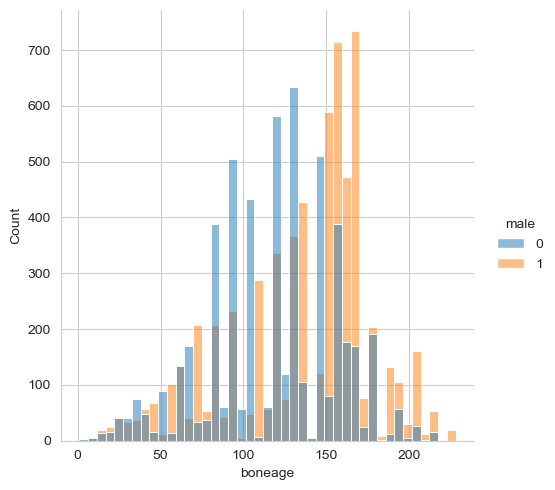

In [3]:
df_train=pd.read_csv("/Users/alisa/Downloads/archive/boneage-training-dataset.csv")
#to tackle this as a classification problem, we map male/female attributes to 1/0
mapper={False : 0, True : 1}
df_train['male']=df_train['male'].map(mapper)
#plot the number of counts for each age for males and females
sns.displot(df_train,x='boneage',hue='male')
age_qcut=pd.qcut(df_train['boneage'],q=3,labels=False,retbins=True,duplicates='drop')
# add a new column with the bone age classifications
df_train['boneage_class']=pd.qcut(df_train['boneage'],q=3,labels=False,duplicates='drop')
# append the.png extension to the image's id
df_train['id']=df_train['id'].apply(lambda id : str(id)+'.png')
# tensorflow's ImageDataLoader requires str, so we updated the data type to str.
df_train['boneage_class']=df_train['boneage_class'].astype('str')

df_val=pd.read_csv("/Users/alisa/Downloads/archive/boneage-validation-dataset.csv")
df_val['male']=df_val['male'].map(mapper)
labels=[i for i in range(len(age_qcut[1])-1)]
df_val['boneage_class']=pd.qcut(df_train['boneage'],q=5,labels=labels,retbins=False,duplicates='drop').astype(str)
df_val['id']=df_val['id'].apply(lambda x : str(x)+'.png')

In [4]:
from keras.preprocessing.image import ImageDataGenerator

#ImageDataGenerator Generates batches of tensor image data with real-time data augmentation.

training_data_generator=ImageDataGenerator(
    rescale=1/255,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True
)
validation_data_generator=ImageDataGenerator(
    rescale=1/255
)

def DataGenerator(generator,df,directory,target_size=(256,256),batch_size=64,seed=40,x_col="id",y_col='boneage_class'):
    df = df.sample(frac=1).reset_index(drop=True)
    data=generator.flow_from_dataframe(df,
                                       directory=directory, #path to the directory to read images from
                                       x_col=x_col,#column in dataframe that contains the filenames
                                       y_col=y_col,#column in dataframe that has the target data.
                                       target_size=target_size, # The dimensions to which all images found will be resized
                                       batch_size=batch_size,#size of the batches of data
                                       class_mode='categorical', #2D numpy array of one-hot encoded labels. Supports multi-label output.
                                       shuffle=False, #whether to shuffle the data
                                       color_mode="rgb" #Whether the images will be converted to have 1 or 3 color channels.
                                       )
    return data

In [5]:
from sklearn.model_selection import train_test_split
df_train,df_val=train_test_split(df_train,test_size=0.1,stratify=df_train['boneage_class'].values.astype(int))
#df_val,df_test=train_test_split(df_val,test_size=0.2,stratify=df_val['boneage_class'].values.astype(int))
#apply the datageneration function to both train and validation data
train_data=DataGenerator(training_data_generator,df_train,directory=path)
val_data=DataGenerator(validation_data_generator,df_val,directory=path)

Found 10540 validated image filenames belonging to 3 classes.
Found 1172 validated image filenames belonging to 3 classes.


In [6]:
df_val

,id,boneage,male,boneage_class
905,2385.png,78,0,0
3614,5577.png,88,0,0
9057,11647.png,168,1,2
5049,7168.png,132,0,1
3680,5654.png,168,1,2
...,...,...,...,...
6929,9256.png,120,1,1
9658,12317.png,108,1,0
6411,8686.png,150,0,1
9306,11924.png,144,0,1


In [7]:
df_train

,id,boneage,male,boneage_class
11486,14362.png,150,1,1
8317,10809.png,159,0,2
2723,4603.png,132,0,1
8799,11351.png,165,1,2
7469,9862.png,50,0,0
...,...,...,...,...
6073,8311.png,82,0,0
254,1662.png,45,1,0
9232,11841.png,138,1,1
2933,4826.png,120,0,1


In [8]:
#build our own model
def custom_model(num_class):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(256, 256, 3)), #Layer to be used as an entry point into a Network

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'), #2D convolution layer
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'), #2D convolution layer
        tf.keras.layers.MaxPool2D(), #Max pooling operation for 2D spatial data

        #first conv block with 32 filters
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'), #Depthwise separable 2D convolution.
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(), #Layer that normalizes its inputs.
        tf.keras.layers.MaxPool2D(),

        #second conv block with 64 filters
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),

        #third conv block with 128 filters
        tf.keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.Dropout(0.2), #Applies Dropout to the input with 0.2 being the Fraction of the input units to drop

        #last conv block with 256 filters
        tf.keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.Dropout(0.2),#Applies Dropout to the input with 0.2 being the Fraction of the input units to drop

        tf.keras.layers.Flatten(), #Flattens the input. Does not affect the batch size.

        #First Dense block 512 units and a dropout rate of 0.7
        tf.keras.layers.Dense(512, activation='relu'), # regular densely-connected NN layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.7),

        #Second Dense block 128 units and a dropout rate of 0.5
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        #Last  Dense block 64 units and a dropout rate of 0.3
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(num_class, activation='softmax')#regular densely-connected NN layer
    ])

    return model

In [9]:
model = custom_model(3) #initializing our model with 5 classes
model.compile(
    optimizer='adam', #Adaptive Moment Estimation also known as Adam optimizer
    loss='categorical_crossentropy', #minimizes the distance between he probabilities of reality and prediction
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'), #Computes the precision of the predictions with respect to the labels
        tf.keras.metrics.Recall(name='recall')]#Computes the recall of the predictions with respect to the labels
)

#Callback to save the  model weights
save_best = tf.keras.callbacks.ModelCheckpoint('/Users/alisa/Downloads/archive/data_analytics.hd5',monitor="val_accuracy",mode='max',verbose=1,save_best_only=True)

callback=[save_best]

2023-07-19 23:21:34.963291: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-07-19 23:21:34.963321: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-19 23:21:34.963326: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-19 23:21:34.963403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-19 23:21:34.963658: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
batch_size=64 #defne desired batch size
with tf.device('/GPU:0'):
    results = model.fit_generator(
        train_data,
        steps_per_epoch=int(len(df_train)/batch_size), #it specifies the total number of steps taken from the generator
        #as soon as one epoch is finished and next epoch has started
        validation_data=val_data,
        validation_steps=int(len(df_val)/batch_size), # total number of steps taken from the generator before it
        #is stopped at every epoch
        epochs=50,
        callbacks=callback
    )

/var/folders/2f/s7rw8pls5yd6df1_193txc6h0000gn/T/ipykernel_36936/1851748797.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(


Epoch 1/50


2023-07-19 23:21:39.924239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - ETA: 0s - loss: 1.2535 - accuracy: 0.3404 - precision: 0.3489 - recall: 0.1502

2023-07-19 23:22:52.064189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.33594, saving model to /Users/alisa/Downloads/archive/data_analytics.hd5
INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 77s 455ms/step - loss: 1.2535 - accuracy: 0.3404 - precision: 0.3489 - recall: 0.1502 - val_loss: 1.1069 - val_accuracy: 0.3359 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
164/164 [==============================] - ETA: 0s - loss: 1.1336 - accuracy: 0.3596 - precision: 0.3972 - recall: 0.0851
Epoch 2: val_accuracy did not improve from 0.33594
164/164 [==============================] - 73s 445ms/step - loss: 1.1336 - accuracy: 0.3596 - precision: 0.3972 - recall: 0.0851 - val_loss: 1.1024 - val_accuracy: 0.3359 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
164/164 [==============================] - ETA: 0s - loss: 1.1180 - accuracy: 0.3655 - precision: 0.4027 - recall: 0.0595
Epoch 3: val_accuracy did not improve from 0.33594
164/164 [==============================] - 74s 450ms/step - loss: 1.1180 - accuracy: 0.3655 - precision: 0.4027 - recall: 0.0595 - val_loss: 1.1007 - val_accuracy: 0.3351 - val_precisi

INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 75s 457ms/step - loss: 1.0990 - accuracy: 0.3803 - precision: 0.4633 - recall: 0.0597 - val_loss: 1.0936 - val_accuracy: 0.3611 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
164/164 [==============================] - ETA: 0s - loss: 1.0886 - accuracy: 0.3952 - precision: 0.4745 - recall: 0.0569
Epoch 5: val_accuracy did not improve from 0.36111
164/164 [==============================] - 73s 442ms/step - loss: 1.0886 - accuracy: 0.3952 - precision: 0.4745 - recall: 0.0569 - val_loss: 1.0919 - val_accuracy: 0.3490 - val_precision: 0.5968 - val_recall: 0.0321
Epoch 6/50
164/164 [==============================] - ETA: 0s - loss: 1.0745 - accuracy: 0.4128 - precision: 0.5140 - recall: 0.0664
Epoch 6: val_accuracy did not improve from 0.36111
164/164 [==============================] - 72s 438ms/step - loss: 1.0745 - accuracy: 0.4128 - precision: 0.5140 - recall: 0.0664 - val_loss: 1.1691 - val_accuracy: 0.3455 - val_precision: 0.36

INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 73s 441ms/step - loss: 1.0510 - accuracy: 0.4450 - precision: 0.5454 - recall: 0.1089 - val_loss: 1.1355 - val_accuracy: 0.3637 - val_precision: 0.4157 - val_recall: 0.2075
Epoch 8/50
164/164 [==============================] - ETA: 0s - loss: 1.0317 - accuracy: 0.4636 - precision: 0.5782 - recall: 0.1613
Epoch 8: val_accuracy improved from 0.36372 to 0.45226, saving model to /Users/alisa/Downloads/archive/data_analytics.hd5
INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 73s 441ms/step - loss: 1.0317 - accuracy: 0.4636 - precision: 0.5782 - recall: 0.1613 - val_loss: 1.0446 - val_accuracy: 0.4523 - val_precision: 0.5595 - val_recall: 0.1510
Epoch 9/50
164/164 [==============================] - ETA: 0s - loss: 1.0123 - accuracy: 0.4772 - precision: 0.5913 - recall: 0.1966
Epoch 9: val_accuracy did not improve from 0.45226
164/164 [==============================] - 71s 433ms/step - loss: 1.0123 - accuracy: 0.4772 - precision: 0.5913 - recall: 0.1966 - val_loss: 1.1567 - val_accuracy: 0.3967 - val_precision: 0.4410 - val_recall: 0.2561
Epoch 10/50
164/164 [==============================] - ETA: 0s - loss: 0.9880 - accuracy: 0.5002 - precision: 0.6125 - recall: 0.2253
Epoch 10: val_accuracy did not improve from 0.45226
164/164 [==============================] - 71s 429ms/step - loss: 0.9880 - accuracy: 0.5002 - precision: 0.6125 - recall: 0.2253 - val_loss: 1.2922 - val_accuracy: 0.3568 - val_precision: 0.3784 - v

INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 73s 442ms/step - loss: 0.9279 - accuracy: 0.5460 - precision: 0.6560 - recall: 0.3247 - val_loss: 0.9431 - val_accuracy: 0.5148 - val_precision: 0.6061 - val_recall: 0.3472
Epoch 14/50
164/164 [==============================] - ETA: 0s - loss: 0.9111 - accuracy: 0.5574 - precision: 0.6602 - recall: 0.3454
Epoch 14: val_accuracy improved from 0.51476 to 0.53993, saving model to /Users/alisa/Downloads/archive/data_analytics.hd5
INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 72s 439ms/step - loss: 0.9111 - accuracy: 0.5574 - precision: 0.6602 - recall: 0.3454 - val_loss: 0.9289 - val_accuracy: 0.5399 - val_precision: 0.6155 - val_recall: 0.3585
Epoch 15/50
164/164 [==============================] - ETA: 0s - loss: 0.9002 - accuracy: 0.5660 - precision: 0.6661 - recall: 0.3561
Epoch 15: val_accuracy did not improve from 0.53993
164/164 [==============================] - 71s 430ms/step - loss: 0.9002 - accuracy: 0.5660 - precision: 0.6661 - recall: 0.3561 - val_loss: 0.9200 - val_accuracy: 0.5304 - val_precision: 0.6230 - val_recall: 0.3429
Epoch 16/50
164/164 [==============================] - ETA: 0s - loss: 0.8725 - accuracy: 0.5846 - precision: 0.6827 - recall: 0.3836
Epoch 16: val_accuracy improved from 0.53993 to 0.56597, saving model to /Users/alisa/Downloads/archive/data_analytics.hd5
INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 73s 441ms/step - loss: 0.8725 - accuracy: 0.5846 - precision: 0.6827 - recall: 0.3836 - val_loss: 0.8820 - val_accuracy: 0.5660 - val_precision: 0.6904 - val_recall: 0.3698
Epoch 17/50
164/164 [==============================] - ETA: 0s - loss: 0.7851 - accuracy: 0.6362 - precision: 0.7139 - recall: 0.4714
Epoch 17: val_accuracy did not improve from 0.56597
164/164 [==============================] - 71s 430ms/step - loss: 0.7851 - accuracy: 0.6362 - precision: 0.7139 - recall: 0.4714 - val_loss: 1.2165 - val_accuracy: 0.5000 - val_precision: 0.5207 - val_recall: 0.4149
Epoch 18/50
164/164 [==============================] - ETA: 0s - loss: 0.7351 - accuracy: 0.6634 - precision: 0.7257 - recall: 0.5288
Epoch 18: val_accuracy improved from 0.56597 to 0.59288, saving model to /Users/alisa/Downloads/archive/data_analytics.hd5
INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 71s 435ms/step - loss: 0.7351 - accuracy: 0.6634 - precision: 0.7257 - recall: 0.5288 - val_loss: 0.8274 - val_accuracy: 0.5929 - val_precision: 0.6301 - val_recall: 0.4939
Epoch 19/50
164/164 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.6799 - precision: 0.7323 - recall: 0.5724
Epoch 19: val_accuracy improved from 0.59288 to 0.68837, saving model to /Users/alisa/Downloads/archive/data_analytics.hd5
INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 73s 442ms/step - loss: 0.6980 - accuracy: 0.6799 - precision: 0.7323 - recall: 0.5724 - val_loss: 0.6910 - val_accuracy: 0.6884 - val_precision: 0.7368 - val_recall: 0.5807
Epoch 20/50
164/164 [==============================] - ETA: 0s - loss: 0.6729 - accuracy: 0.6916 - precision: 0.7429 - recall: 0.6018
Epoch 20: val_accuracy did not improve from 0.68837
164/164 [==============================] - 71s 432ms/step - loss: 0.6729 - accuracy: 0.6916 - precision: 0.7429 - recall: 0.6018 - val_loss: 0.6895 - val_accuracy: 0.6684 - val_precision: 0.7154 - val_recall: 0.5738
Epoch 21/50
164/164 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.7027 - precision: 0.7486 - recall: 0.6248
Epoch 21: val_accuracy did not improve from 0.68837
164/164 [==============================] - 71s 429ms/step - loss: 0.6502 - accuracy: 0.7027 - precision: 0.7486 - recall: 0.6248 - val_loss: 0.7374 - val_accuracy: 0.6562 - val_precision: 0.6904 -

INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 73s 441ms/step - loss: 0.5981 - accuracy: 0.7345 - precision: 0.7654 - recall: 0.6825 - val_loss: 0.6306 - val_accuracy: 0.7101 - val_precision: 0.7310 - val_recall: 0.6675
Epoch 25/50
164/164 [==============================] - ETA: 0s - loss: 0.5834 - accuracy: 0.7409 - precision: 0.7694 - recall: 0.6903
Epoch 25: val_accuracy did not improve from 0.71007
164/164 [==============================] - 71s 429ms/step - loss: 0.5834 - accuracy: 0.7409 - precision: 0.7694 - recall: 0.6903 - val_loss: 0.6645 - val_accuracy: 0.6832 - val_precision: 0.7079 - val_recall: 0.6502
Epoch 26/50
164/164 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.7477 - precision: 0.7754 - recall: 0.7045
Epoch 26: val_accuracy did not improve from 0.71007
164/164 [==============================] - 71s 431ms/step - loss: 0.5761 - accuracy: 0.7477 - precision: 0.7754 - recall: 0.7045 - val_loss: 0.6990 - val_accuracy: 0.6832 - val_precision: 0.7079 -

INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 73s 441ms/step - loss: 0.5551 - accuracy: 0.7566 - precision: 0.7800 - recall: 0.7201 - val_loss: 0.6315 - val_accuracy: 0.7109 - val_precision: 0.7292 - val_recall: 0.6849
Epoch 29/50
164/164 [==============================] - ETA: 0s - loss: 0.5361 - accuracy: 0.7716 - precision: 0.7926 - recall: 0.7354
Epoch 29: val_accuracy did not improve from 0.71094
164/164 [==============================] - 71s 429ms/step - loss: 0.5361 - accuracy: 0.7716 - precision: 0.7926 - recall: 0.7354 - val_loss: 0.6448 - val_accuracy: 0.6927 - val_precision: 0.7191 - val_recall: 0.6623
Epoch 30/50
164/164 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.7697 - precision: 0.7922 - recall: 0.7360
Epoch 30: val_accuracy did not improve from 0.71094
164/164 [==============================] - 72s 437ms/step - loss: 0.5275 - accuracy: 0.7697 - precision: 0.7922 - recall: 0.7360 - val_loss: 0.6381 - val_accuracy: 0.6988 - val_precision: 0.7227 -

INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 73s 442ms/step - loss: 0.5212 - accuracy: 0.7740 - precision: 0.7970 - recall: 0.7460 - val_loss: 0.6096 - val_accuracy: 0.7231 - val_precision: 0.7384 - val_recall: 0.7057
Epoch 32/50
164/164 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.7799 - precision: 0.8004 - recall: 0.7494
Epoch 32: val_accuracy did not improve from 0.72309
164/164 [==============================] - 71s 433ms/step - loss: 0.5103 - accuracy: 0.7799 - precision: 0.8004 - recall: 0.7494 - val_loss: 0.7138 - val_accuracy: 0.6788 - val_precision: 0.6906 - val_recall: 0.6606
Epoch 33/50
164/164 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.7813 - precision: 0.8001 - recall: 0.7542
Epoch 33: val_accuracy improved from 0.72309 to 0.72830, saving model to /Users/alisa/Downloads/archive/data_analytics.hd5
INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 74s 448ms/step - loss: 0.5081 - accuracy: 0.7813 - precision: 0.8001 - recall: 0.7542 - val_loss: 0.5880 - val_accuracy: 0.7283 - val_precision: 0.7347 - val_recall: 0.7092
Epoch 34/50
164/164 [==============================] - ETA: 0s - loss: 0.4906 - accuracy: 0.7892 - precision: 0.8068 - recall: 0.7623
Epoch 34: val_accuracy did not improve from 0.72830
164/164 [==============================] - 71s 434ms/step - loss: 0.4906 - accuracy: 0.7892 - precision: 0.8068 - recall: 0.7623 - val_loss: 0.7072 - val_accuracy: 0.6858 - val_precision: 0.6991 - val_recall: 0.6675
Epoch 35/50
164/164 [==============================] - ETA: 0s - loss: 0.4915 - accuracy: 0.7907 - precision: 0.8092 - recall: 0.7653
Epoch 35: val_accuracy did not improve from 0.72830
164/164 [==============================] - 71s 430ms/step - loss: 0.4915 - accuracy: 0.7907 - precision: 0.8092 - recall: 0.7653 - val_loss: 0.5989 - val_accuracy: 0.7135 - val_precision: 0.7263 -

INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 74s 452ms/step - loss: 0.4677 - accuracy: 0.8023 - precision: 0.8163 - recall: 0.7792 - val_loss: 0.5782 - val_accuracy: 0.7292 - val_precision: 0.7411 - val_recall: 0.7205
Epoch 39/50
164/164 [==============================] - ETA: 0s - loss: 0.4582 - accuracy: 0.8055 - precision: 0.8196 - recall: 0.7865
Epoch 39: val_accuracy did not improve from 0.72917
164/164 [==============================] - 74s 447ms/step - loss: 0.4582 - accuracy: 0.8055 - precision: 0.8196 - recall: 0.7865 - val_loss: 0.6083 - val_accuracy: 0.7274 - val_precision: 0.7351 - val_recall: 0.7153
Epoch 40/50
164/164 [==============================] - ETA: 0s - loss: 0.4550 - accuracy: 0.8076 - precision: 0.8203 - recall: 0.7850
Epoch 40: val_accuracy improved from 0.72917 to 0.73785, saving model to /Users/alisa/Downloads/archive/data_analytics.hd5
INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 75s 453ms/step - loss: 0.4550 - accuracy: 0.8076 - precision: 0.8203 - recall: 0.7850 - val_loss: 0.5703 - val_accuracy: 0.7378 - val_precision: 0.7442 - val_recall: 0.7300
Epoch 41/50
164/164 [==============================] - ETA: 0s - loss: 0.4482 - accuracy: 0.8069 - precision: 0.8238 - recall: 0.7888
Epoch 41: val_accuracy did not improve from 0.73785
164/164 [==============================] - 75s 454ms/step - loss: 0.4482 - accuracy: 0.8069 - precision: 0.8238 - recall: 0.7888 - val_loss: 0.6072 - val_accuracy: 0.7361 - val_precision: 0.7411 - val_recall: 0.7205
Epoch 42/50
164/164 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.8183 - precision: 0.8322 - recall: 0.7992
Epoch 42: val_accuracy did not improve from 0.73785
164/164 [==============================] - 74s 450ms/step - loss: 0.4382 - accuracy: 0.8183 - precision: 0.8322 - recall: 0.7992 - val_loss: 0.6929 - val_accuracy: 0.7057 - val_precision: 0.7174 -

INFO:tensorflow:Assets written to: /Users/alisa/Downloads/archive/data_analytics.hd5/assets


164/164 [==============================] - 73s 444ms/step - loss: 0.4184 - accuracy: 0.8304 - precision: 0.8414 - recall: 0.8128 - val_loss: 0.5751 - val_accuracy: 0.7387 - val_precision: 0.7458 - val_recall: 0.7335
Epoch 50/50
164/164 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8329 - precision: 0.8436 - recall: 0.8167
Epoch 50: val_accuracy did not improve from 0.73872
164/164 [==============================] - 71s 432ms/step - loss: 0.4063 - accuracy: 0.8329 - precision: 0.8436 - recall: 0.8167 - val_loss: 0.6367 - val_accuracy: 0.7248 - val_precision: 0.7291 - val_recall: 0.7127


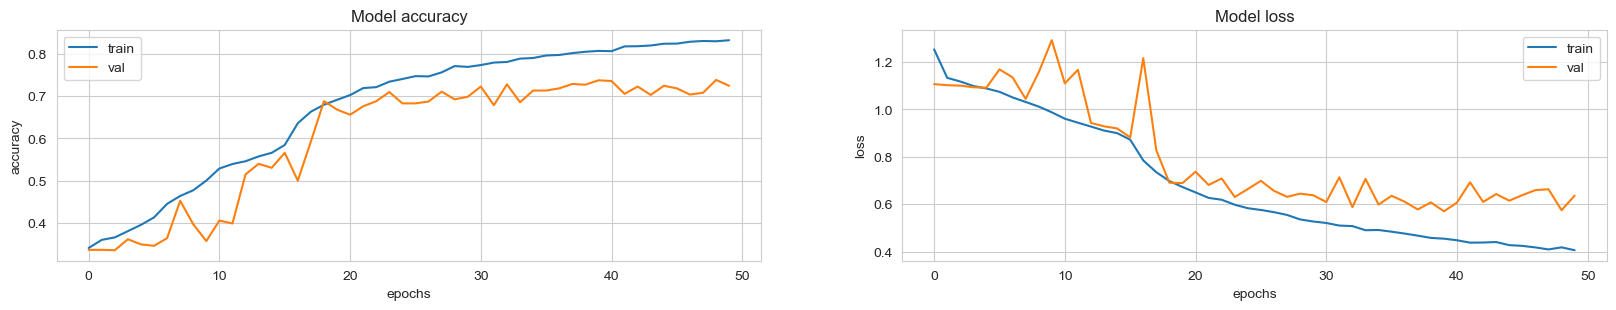

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(results.history[met])
    ax[i].plot(results.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.show()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 separable_conv2d (Separabl  (None, 128, 128, 32)      688       
 eConv2D)                                                        
                                                                 
 separable_conv2d_1 (Separa  (None, 128, 128, 32)      1344      
 bleConv2D)                                                      
                                                        